In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import tools

In [27]:
# plt.style.use("coolbeans")
sns.set_style("whitegrid")
np.random.seed(123)

In [28]:
DB_PATH = "./data/stationdb.sqlite"
TCR_PATH = "./data/20th_rean_V2.npz"
ERSST_PATH = "./data/ersst.npz"
WATER_YEAR = {"low": 1950,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}
WESTOFLON = -104
EASTOFLON = -125
MC_NRUNS = 500

In [29]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, year, mean FROM StationWY WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, year ORDER BY stationid, year ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [30]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map


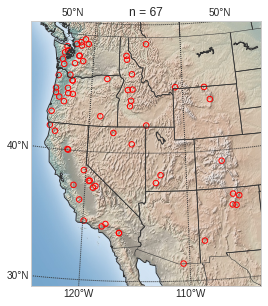

In [31]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Mapped SSI linear trend

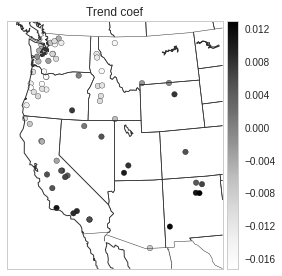

In [32]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["mean"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "stationid").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
# parsed = parsed.unstack()

# Map trend coefs.
out = tools.plot_trendmap(trend_coefs, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Basic North Test scree plot

In [33]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 6
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

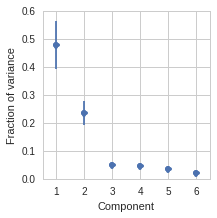

In [34]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [35]:
retain_modes = 2

## PC time series from leading components

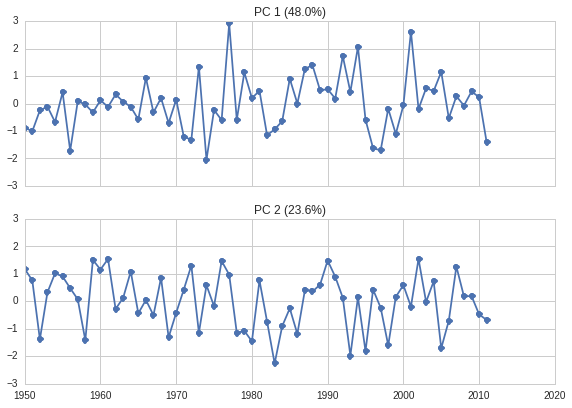

In [36]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

/usr/local/lib/python3.4/dist-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


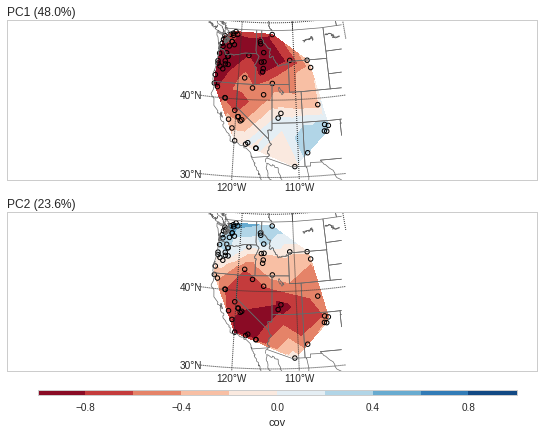

In [37]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes)

## Leading two modes as vectors

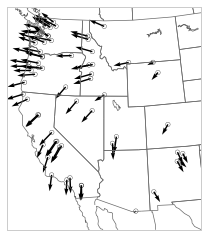

In [38]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

## Northern hemisphere NDJ 500 mb geopotential height

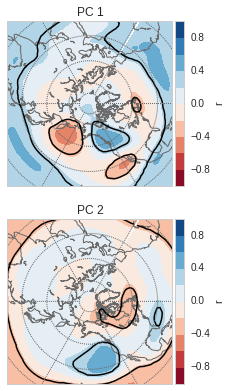

In [39]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts,
                         lat = tcr["lat"], lon = tcr["lon"],
                         nmodes = retain_modes)

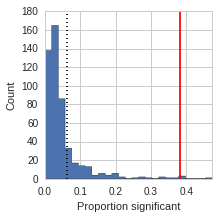

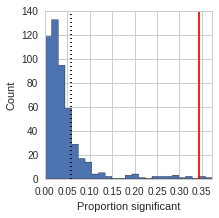

In [40]:
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], hgts.copy(), 
                                                           tcr["lat"], 
                                                           local_alpha = 0.05, 
                                                           nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended NDJ global SST

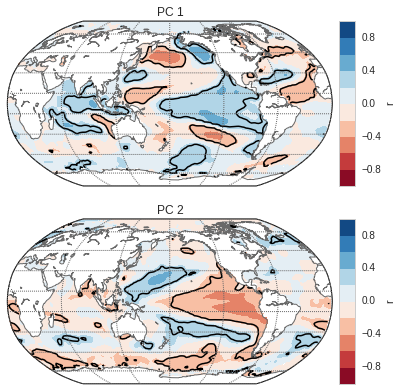

In [41]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

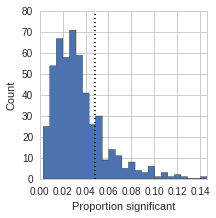

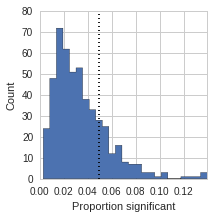

In [42]:
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], sst.copy(), 
                                                           ersst["lat"], 
                                                           local_alpha = 0.05, 
                                                           nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

# Composite maps

## Northern hemisphere NDJ 500 mb geopotential height

In [43]:
tcr = np.load(TCR_PATH)
msk_time = (tcr["time"] >= WATER_YEAR["low"]) & (tcr["time"] <= WATER_YEAR["high"])
hgts = tcr["data"][0, 1, msk_time]

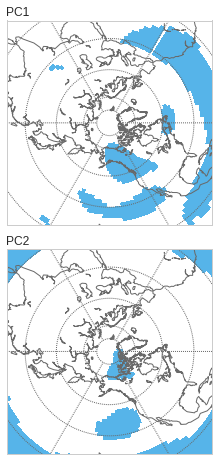

In [44]:
out = tools.plot_ttest(solver, hgts, 
                       lat = tcr["lat"], lon = tcr["lon"], 
                       nmodes = retain_modes, alpha = 0.05)

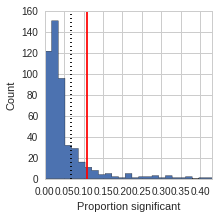

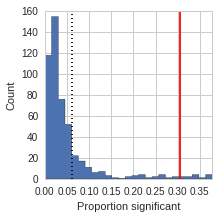

In [45]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], hgts.copy(), 
                                                         tcr["lat"],
                                                         local_alpha = 0.05, 
                                                         nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended NDJ global SST

In [46]:
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= WATER_YEAR["low"]) & (ersst["time"] <= WATER_YEAR["high"])
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)

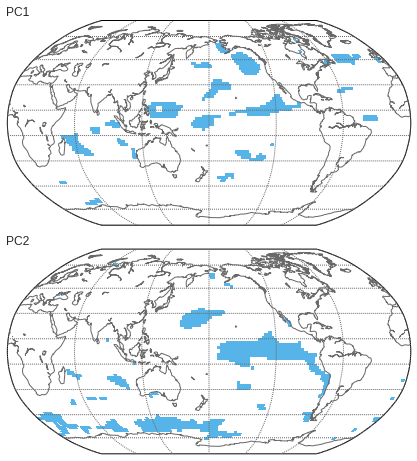

In [47]:
out = tools.plot_ttest(solver, sst, 
                         lat = ersst["lat"], lon = ersst["lon"], 
                         nmodes = retain_modes, 
                         msk = ersst["landmask"], world_map = True)

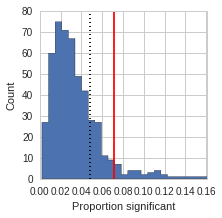

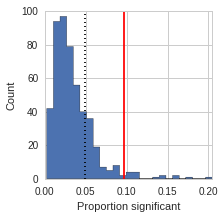

In [48]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], sst.copy(), 
                                                         ersst["lat"], 
                                                         local_alpha = 0.05, 
                                                         nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)